In [1]:
exp <- "Flt3l"
outdir <- "/data2/mito_lineage/Analysis/annotation/output/data/"
prefix <- "CHIP_april08_2021_Croker/MTblacklist/"
external_dat_file <- "granja_10X_CD34.rds"
#external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/output/data/"
#nTop = 25000
workers = 12
assay="RNA" # RNA, ATAC

In [2]:
library(future)
plan()
plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

In [3]:
library(Seurat)
library(SummarizedExperiment)
library(cowplot)
library(ggplot2)
library(cowplot)
library(patchwork)

Attaching SeuratObject

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDif

In [5]:
outdir <- file.path(outdir, prefix)
outdir

[1] "/data2/mito_lineage/Analysis/annotation/output/data//CHIP_april08_2021_Croker/MTblacklist/"

## Import granja data

In [7]:
curr_SE <- readRDS(file.path(outdir, paste0(exp, ".cd34.rds")))
ext_SE <- readRDS(file.path(outdir, external_dat_file))

In [8]:
curr_SE[['tech']] <- exp
ext_SE[['tech']] <-'granja_cd34'

Loading required package: Signac



In [9]:
C1boo <- subset(x = ext_SE, subset = Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP"))
C1boo
#C1boo <-  ext_SE[[1, 'Group']] %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
#C1boo

An object of class Seurat 
586167 features across 2196 samples within 2 assays 
Active assay: peaks (566210 features, 566210 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: lsi, umap

In [10]:
DefaultAssay(C1boo) <- assay
DefaultAssay(curr_SE) <- assay

In [11]:
scatac.list <- c(C1boo, curr_SE)


In [15]:
for (i in 1:length(scatac.list)) {
    scatac.list[[i]] <- NormalizeData(scatac.list[[i]], verbose = TRUE)
    scatac.list[[i]] <- FindVariableFeatures(scatac.list[[i]], nfeatures = 2000,
        verbose = TRUE)
}

## Integrate anchors

In [16]:
reference.list <- scatac.list[c(1,2)]
#reference.list <- scatac.list[c(1)]
scatac.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:30,)


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8937 anchors

Filtering anchors

	Retained 2161 anchors



In [17]:
scatac.integrated <- IntegrateData(anchorset = scatac.anchors, dims = 1:30)


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows


Binding matrix rows

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



## Plot batch and external group on umap

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


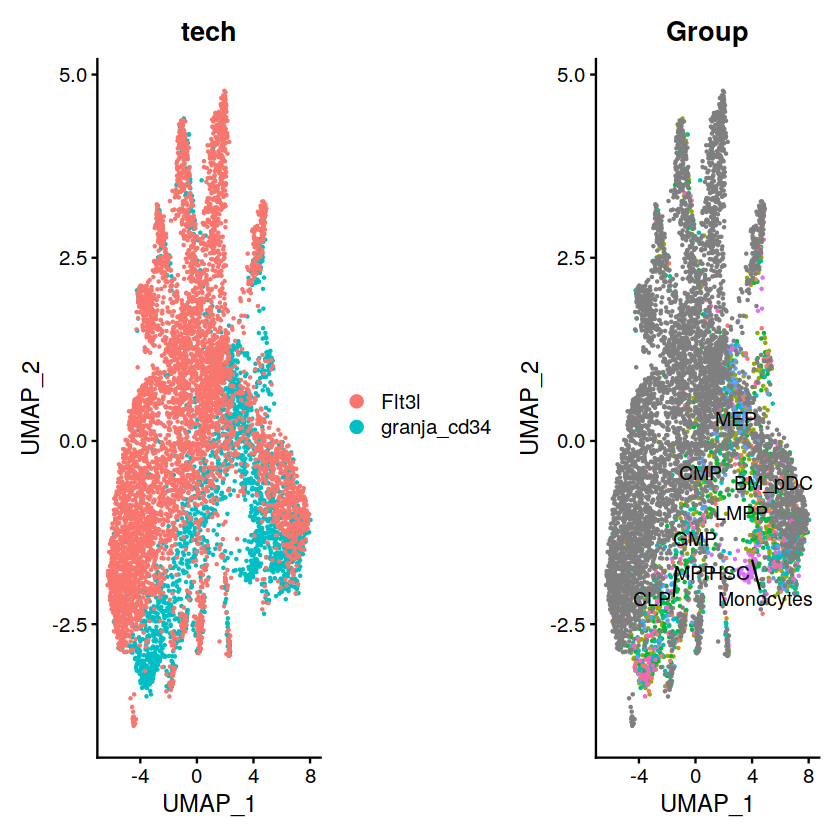

In [18]:
# switch to integrated assay. The variable features of this assay are automatically set during
# IntegrateData
DefaultAssay(scatac.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
scatac.integrated <- ScaleData(scatac.integrated, verbose = FALSE)
scatac.integrated <- RunPCA(scatac.integrated, npcs = 30, verbose = FALSE)
scatac.integrated <- RunUMAP(scatac.integrated, reduction = "pca", dims = 1:30, verbose = FALSE)
p1 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "tech")
p2 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "Group", label = TRUE, repel = TRUE) +
    NoLegend()
p1 + p2
cowplot::ggsave2(p1, file = file.path(outdir, paste0(exp, ".merged.anchors.labels.png")), width = 1.7, height = 1.7)

## Transfer labels from reference to sample

In [ ]:
scatac.query <- scatac.list[[2]]
scatac.anchors <- FindTransferAnchors(reference = scatac.integrated, query = scatac.query,
    dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = scatac.anchors, refdata = scatac.integrated$Group,
    dims = 1:30)
scatac.query <- AddMetaData(scatac.query, metadata = predictions)

In [27]:
scatac.integrated$Group

Monocytes#ATTTGTCCACAGAAGC-1 
                               "Monocytes" 
              Monocytes#ACTGCAATCTTCCAGC-1 
                               "Monocytes" 
              Monocytes#CCGAAGCGTCGTAGTT-1 
                               "Monocytes" 
              Monocytes#TGGAAGGCAAGGCGTA-1 
                               "Monocytes" 
              Monocytes#CGCACAGGTCACCCGA-1 
                               "Monocytes" 
              Monocytes#TTGCACCGTGAATCAA-1 
                               "Monocytes" 
              Monocytes#AATGGCTGTACATGGG-1 
                               "Monocytes" 
              Monocytes#ACTATTCGTCTCGGGT-1 
                               "Monocytes" 
              Monocytes#AGTGCGCTCGTCGCAG-1 
                               "Monocytes" 
              Monocytes#ACAGCGCTCACTCGGG-1 
                               "Monocytes" 
              Monocytes#CTCTCGAAGAAATGGG-1 
                               "Monocytes" 
              Monocytes#ACCATCCGTCGCTAGC-1 
                               "Monocytes" 
              Monocytes#AACCTTTCAACAAACA-1 
                               "Monocytes" 
              Monocytes#CTAGCGGTCGTGCTTC-1 
                               "Monocytes" 
              Monocytes#TTATGTCTCATTGCCC-1 
                               "Monocytes" 
              Monocytes#GTGCCAGGTTCCTATT-1 
                               "Monocytes" 
              Monocytes#GGATAGGAGATGAGGA-1 
                               "Monocytes" 
              Monocytes#AGCCTGGAGAACGCCA-1 
                               "Monocytes" 
              Monocytes#AACAAAGTCTTACTCA-1 
                               "Monocytes" 
              Monocytes#GGCGAAAGTGCGCATC-1 
                               "Monocytes" 
              Monocytes#CAGCTAACACGCGCAT-1 
                               "Monocytes" 
              Monocytes#CTTGAAGAGAGTTCGG-1 
                               "Monocytes" 
              Monocytes#GCGAGTCCACAAACAA-1 
                               "Monocytes" 
              Monocytes#GCATGATAGCTACGTT-1 
                               "Monocytes" 
              Monocytes#CACTAAGAGGCCAATG-1 
                               "Monocytes" 
              Monocytes#AATACGCAGCGTAGCA-1 
                               "Monocytes" 
              Monocytes#ACTGCGGAGGCAATTA-1 
                               "Monocytes" 
              Monocytes#GTTATTCTCGGTCTAA-1 
                               "Monocytes" 
              Monocytes#GCCCAGAAGTGTTCCA-1 
                               "Monocytes" 
              Monocytes#CCTTGCAGTATTCTTC-1 
                               "Monocytes" 
              Monocytes#GGAGAACAGAGCAGCT-1 
                               "Monocytes" 
              Monocytes#TTAGCGAGTGACGCAA-1 
                               "Monocytes" 
              Monocytes#TCAGGGCAGCATGATA-1 
                               "Monocytes" 
              Monocytes#TACATTCCAGATACAA-1 
                               "Monocytes" 
              Monocytes#GTGACATCATCGTACA-1 
                               "Monocytes" 
              Monocytes#GCTGTTCGTACGTATC-1 
                               "Monocytes" 
              Monocytes#TGACAACAGTCTGGGA-1 
                               "Monocytes" 
              Monocytes#GCTCAGGTCTAGCTGA-1 
                               "Monocytes" 
              Monocytes#GGCGTTGTCCCACTAC-1 
                               "Monocytes" 
              Monocytes#AGCCGCAAGGCAGTAC-1 
                               "Monocytes" 
              Monocytes#GAACTTGGTCTGAGCC-1 
                               "Monocytes" 
              Monocytes#GTAGTACCAATACTGC-1 
                               "Monocytes" 
              Monocytes#ATTACTCTCGCGCCAA-1 
                               "Monocytes" 
              Monocytes#AACAGTCCATCGTACA-1 
                               "Monocytes" 
              Monocytes#AGCCTTCTCCTTACGC-1 
                               "Monocytes" 
              Monocytes#TGCTATTGTTCCATCC-1 
          

In [28]:
table(scatac.query$predicted.id)



   BM_pDC       CLP       CMP       GMP       HSC      LMPP       MEP Monocytes 
       86        94       579       686       355        84       249      3093 
      MPP 
       86 

In [ ]:
scatac.integrated <- RunUMAP(scatac.integrated, dims = 1:30, reduction = "pca", return.model = TRUE)
scatac.query <- MapQuery(anchorset = scatac.anchors, reference = scatac.integrated, query = scatac.query,
    refdata = list(celltype = "celltype"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

16:32:13 UMAP embedding parameters a = 0.9922 b = 1.112

16:32:13 Read 7508 rows and found 30 numeric columns

16:32:13 Using Annoy for neighbor search, n_neighbors = 30

16:32:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:32:14 Writing NN index file to temp file /tmp/Rtmpw96DVv/file6951a524b51

16:32:14 Searching Annoy index using 1 thread, search_k = 3000

16:32:17 Annoy recall = 100%

16:32:18 Commencing smooth kNN distance calibration using 1 thread

16:32:20 Initializing from normalized Laplacian + noise

16:32:20 Commencing optimization for 500 epochs, with 332002 positive edges

16:32:32 Optimization finished

Warning message:
“Element number 1 provided to refdata does not exist in the provided reference object.”


In [ ]:
p1 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "celltype", label = TRUE, label.size = 3,
    repel = TRUE) + NoLegend() + ggtitle("Reference annotations")
p2 <- DimPlot(scatac.query, reduction = "ref.umap", group.by = "predicted.celltype", label = TRUE,
    label.size = 3, repel = TRUE) + NoLegend() + ggtitle("Query transferred labels")
p1 + p2
cowplot::ggsave2(p1+p2, file = file.path(outdir, paste0(exp, ".merged.anchors.sample.labels.png")), width = 1.7, height = 1.7)

In [ ]:
p1 + p2

## Save!

### Save cell labels and integrated signac file

In [ ]:
write.table(scatac.integrated[, "celltype", drop=FALSE], file = file.path(outdir, paste0(exp, ".clusters.csv")), col.names=FALSE,
          row.names=TRUE, quote=FALSE, sep=",")

In [ ]:
saveRDS(scatac.integrated, file.path(outdir, paste0(exp, "scatac.integrated.rds"))#file.path(outdir, "scatac.integrated.rds" ))

# Unimodal UMAP Projection


In [ ]:
scatac.integrated <- RunUMAP(scatac.integrated, dims = 1:30, reduction = "pca", return.model = TRUE)
scatac.query <- MapQuery(anchorset = scatac.anchors, reference = scatac.integrated, query = scatac.query,
    refdata = list(celltype = "celltype"), reference.reduction = "pca", reduction.model = "umap")

In [ ]:
scatac.query <- TransferData(anchorset = scatac.anchors, reference = scatac.integrated, query = scatac.query,
    refdata = list(celltype = "celltype"))
scatac.query <- IntegrateEmbeddings(anchorset = scatac.anchors, reference = scatac.integrated,
    query = scatac.query, new.reduction.name = "ref.pca")
scatac.query <- ProjectUMAP(query = scatac.query, query.reduction = "ref.pca", reference = scatac.integrated,
    reference.reduction = "pca", reduction.model = "umap")


In [ ]:
p1 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "celltype", label = TRUE, label.size = 3,
    repel = TRUE) + NoLegend() + ggtitle("Reference annotations")
p2 <- DimPlot(scatac.query, reduction = "ref.umap", group.by = "predicted.celltype", label = TRUE,
    label.size = 3, repel = TRUE) + NoLegend() + ggtitle("Query transferred labels")
p1 + p2